# Entrenamiento de Modelos de Corrosión Acuática con K-Fold Cross Validation


## 1. Importación de Librerías
En esta sección se importan todas las librerías necesarias para el procesamiento de datos, entrenamiento de modelos y visualización.


In [1]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from ultralytics import YOLO
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Función para limpiar la memoria de la GPU
def clear_gpu_cache():
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)
        print(f"Caché de la GPU limpiada en dispositivo {device}.")
    else:
        print("CUDA no está disponible.")

clear_gpu_cache()


CUDA no está disponible.


## 2. Carga y Preparación del Dataset
Se definen las rutas del dataset, se preparan las listas de imágenes y se configura el directorio de salida. También se define la configuración global.


In [2]:
# Rutas
if 'ORIGINAL_DATASET_PATH' not in locals():
    ORIGINAL_DATASET_PATH = Path('./dataset_yolo') # Ajusta si es necesario
    
images_dir = ORIGINAL_DATASET_PATH / 'images'
labels_dir = ORIGINAL_DATASET_PATH / 'labels'
OUTPUT_DIR = Path('./modelos_entrenados')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuración Global
PROJECT_NAME = 'Corrosion_Benchmark'
EPOCHS = 50

# Recolectar imágenes
all_image_paths = sorted(list(images_dir.rglob('*.jpg')) + list(images_dir.rglob('*.png')))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(f'Dataset encontrado en: {ORIGINAL_DATASET_PATH}')
print(f'Total imágenes: {len(all_image_paths)}')
print(f'Directorio de salida: {OUTPUT_DIR}')


Dataset encontrado en: dataset_yolo
Total imágenes: 261
Directorio de salida: modelos_entrenados


## 3. Entrenamiento de Modelos
Entrenamiento de los modelos YOLOv12 (Nano, Medium, Large) utilizando validación cruzada de 5 pliegues (K-Fold).


### 3.1. Entrenamiento YOLOv12 NANO
Se entrena el modelo Nano (yolo12n.pt) con los parámetros configurados.


In [4]:
# --- PARÁMETROS NANO ---
MODEL_NAME = 'yolo12n.pt'
SUFFIX = 'n'
BATCH_SIZE = 16
IMG_SIZE = 640

print(f'{"="*60}')
print(f' ARQUITECTURA: {MODEL_NAME.upper()} (imgsz={IMG_SIZE})')
print(f'{"="*60}')

best_map50_arch = 0.0
best_weights_path_arch = ''
fold_metrics = []

for fold_idx, (train_index, val_index) in enumerate(kf.split(all_image_paths)):
    print(f'--- {SUFFIX.upper()} | Fold {fold_idx + 1}/5 ---')
    
    # 1. Preparar temporales
    fold_dir = Path(f'temp_data/{SUFFIX}/fold_{fold_idx}')
    if fold_dir.exists(): shutil.rmtree(fold_dir)
    (fold_dir / 'images/train').mkdir(parents=True, exist_ok=True)
    (fold_dir / 'images/val').mkdir(parents=True, exist_ok=True)
    (fold_dir / 'labels/train').mkdir(parents=True, exist_ok=True)
    (fold_dir / 'labels/val').mkdir(parents=True, exist_ok=True)
    
    # 2. Copiar Archivos
    def copy_files(indices, split_name):
        for idx in indices:
            img_path = all_image_paths[idx]
            shutil.copy(img_path, fold_dir / 'images' / split_name / img_path.name)
            
            label_name = img_path.stem + '.txt'
            final_lbl = None
            try:
                rel = img_path.relative_to(images_dir)
                poss = labels_dir / rel.with_suffix('.txt')
                if poss.exists(): final_lbl = poss
            except: pass
            
            if final_lbl is None:
                poss = labels_dir / label_name
                if poss.exists(): final_lbl = poss
                else:
                    found = list(labels_dir.rglob(label_name))
                    if found: final_lbl = found[0]
            
            if final_lbl:
                shutil.copy(final_lbl, fold_dir / 'labels' / split_name / label_name)

    copy_files(train_index, 'train')
    copy_files(val_index, 'val')
    
    # 3. YAML
# 3. YAML
yaml_path = fold_dir / 'data.yaml'
with open(yaml_path, 'w') as f:
    f.write(f'path: {fold_dir.absolute()}\ntrain: images/train\nval: images/val\nnames:\n  0: corrosion')
# 4. Entrenar
clear_gpu_cache()
model = YOLO(MODEL_NAME)
run_name = f'{SUFFIX}_fold_{fold_idx+1}'

model.train(
    data=str(yaml_path), 
    epochs=EPOCHS, 
    imgsz=IMG_SIZE, 
    batch=BATCH_SIZE,
    project=PROJECT_NAME, 
    name=run_name, 
    augment=True,
    optimizer='SGD',
    lr0=0.01,
    lrf=0.1,
    momentum=0.937,
    weight_decay=0.0005,
    exist_ok=True, 
    verbose=False, 
    plots=False
)

# 5. Validar
metrics = model.val(split='val', verbose=False, plots=False)
current_map = metrics.box.map50
fold_metrics.append(current_map)
print(f'    -> mAP@50: {current_map:.4f}')

if current_map > best_map50_arch:
    best_map50_arch = current_map
    best_weights_path_arch = Path(PROJECT_NAME) / run_name / 'weights' / 'best.pt'

# --- CIERRE ---
dest = OUTPUT_DIR / f'modelo-acuatico-{SUFFIX}.pt'
if best_weights_path_arch:
    shutil.copy(best_weights_path_arch, dest)
    print(f'\n✅ GUARDADO: {dest}')

results_df = pd.DataFrame([{ 
'Modelo': f'YOLOv12-{SUFFIX.upper()}',
'mAP@50 (Mean)': np.mean(fold_metrics),
'Std Dev': np.std(fold_metrics),
'Best Fold': best_map50_arch
}])
print('\n RESULTADOS NANO:')


 ARQUITECTURA: YOLO12N.PT (imgsz=640)
--- N | Fold 1/5 ---
--- N | Fold 2/5 ---
--- N | Fold 3/5 ---
--- N | Fold 4/5 ---
--- N | Fold 5/5 ---
CUDA no está disponible.
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.228 🚀 Python-3.9.13 torch-2.8.0+cu128 CPU (AMD Ryzen 7 5800X 8-Core Processor)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=temp_data/n/fold_4/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None,

KeyboardInterrupt: 

### 3.2. Entrenamiento YOLOv12 MEDIUM
Se entrena el modelo Medium (yolo12m.pt) con los parámetros configurados.


In [6]:
# --- PARÁMETROS MEDIUM ---
MODEL_NAME = 'yolo12m.pt'
SUFFIX = 'm'
BATCH_SIZE = 8
IMG_SIZE = 640

print(f"\n{'='*60}")
print(f' ARQUITECTURA: {MODEL_NAME.upper()} (imgsz={IMG_SIZE})')
print(f"{'='*60}")

best_map50_arch = 0.0
best_weights_path_arch = ''
fold_metrics = []

for fold_idx, (train_index, val_index) in enumerate(kf.split(all_image_paths)):
    print(f'--- {SUFFIX.upper()} | Fold {fold_idx + 1}/5 ---')
    
    fold_dir = Path(f'temp_data/{SUFFIX}/fold_{fold_idx}')
    if fold_dir.exists(): shutil.rmtree(fold_dir)
    (fold_dir / 'images/train').mkdir(parents=True, exist_ok=True)
    (fold_dir / 'images/val').mkdir(parents=True, exist_ok=True)
    (fold_dir / 'labels/train').mkdir(parents=True, exist_ok=True)
    (fold_dir / 'labels/val').mkdir(parents=True, exist_ok=True)
    
    def copy_files(indices, split_name):
        for idx in indices:
            img_path = all_image_paths[idx]
            shutil.copy(img_path, fold_dir / 'images' / split_name / img_path.name)
            label_name = img_path.stem + '.txt'
            final_lbl = None
            try:
                rel = img_path.relative_to(images_dir)
                poss = labels_dir / rel.with_suffix('.txt')
                if poss.exists(): final_lbl = poss
            except: pass
            if final_lbl is None:
                poss = labels_dir / label_name
                if poss.exists(): final_lbl = poss
                else:
                    found = list(labels_dir.rglob(label_name))
                    if found: final_lbl = found[0]
            if final_lbl:
                shutil.copy(final_lbl, fold_dir / 'labels' / split_name / label_name)

    copy_files(train_index, 'train')
    copy_files(val_index, 'val')
    
yaml_path = fold_dir / 'data.yaml'
with open(yaml_path, 'w') as f:
    content = (f'path: {fold_dir.absolute()}\n'
               'train: images/train\n'
               'val: images/val\n'
               'names:\n'
               '  0: corrosion\n')
    f.write(content)
    
clear_gpu_cache()
model = YOLO(MODEL_NAME)
run_name = f'{SUFFIX}_fold_{fold_idx+1}'
    
model.train(
    data=str(yaml_path), 
    epochs=EPOCHS, 
    imgsz=IMG_SIZE, 
    batch=BATCH_SIZE,
    project=PROJECT_NAME, 
    name=run_name, 
    augment=True,       
    optimizer='SGD',    
    lr0=0.01,           
    lrf=0.1,            
    momentum=0.937,     
    weight_decay=0.0005,
    exist_ok=True, 
    verbose=False, 
    plots=False
)
    
metrics = model.val(split='val', verbose=False, plots=False)
current_map = metrics.box.map50
fold_metrics.append(current_map)
print(f'    -> mAP@50: {current_map:.4f}')
    
if current_map > best_map50_arch:
    best_map50_arch = current_map
    best_weights_path_arch = Path(PROJECT_NAME) / run_name / 'weights' / 'best.pt'
dest = OUTPUT_DIR / f'modelo-acuatico-{SUFFIX}.pt'
if best_weights_path_arch:
    shutil.copy(best_weights_path_arch, dest)
    print(f'\n GUARDADO: {dest}')


results_df = pd.DataFrame([{ 
    'Modelo': f'YOLOv12-{SUFFIX.upper()}',
    'mAP@50 (Mean)': np.mean(fold_metrics),
    'Std Dev': np.std(fold_metrics),
    'Best Fold': best_map50_arch
}])
print('\nRESULTADOS MEDIUM:')
print(results_df.to_string(index=False))



 ARQUITECTURA: YOLO12M.PT (imgsz=640)

--- M | Fold 1/5 ---
--- M | Fold 2/5 ---
--- M | Fold 3/5 ---
--- M | Fold 4/5 ---
--- M | Fold 5/5 ---
CUDA no está disponible.
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.228 🚀 Python-3.9.13 torch-2.8.0+cu128 CPU (AMD Ryzen 7 5800X 8-Core Processor)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=temp_data/m/fold_4/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None

KeyboardInterrupt: 

### 3.3. Entrenamiento YOLOv12 LARGE
Se entrena el modelo Large (yolo12l.pt) con los parámetros configurados.


In [7]:
# --- PARÁMETROS LARGE ---
MODEL_NAME = 'yolo12l.pt'
SUFFIX = 'l'
BATCH_SIZE = 8
IMG_SIZE = 640

print(f"\n{'='*60}")
print(f' ARQUITECTURA: {MODEL_NAME.upper()} (imgsz={IMG_SIZE})')
print(f"{'='*60}")

best_map50_arch = 0.0
best_weights_path_arch = ''
fold_metrics = []

for fold_idx, (train_index, val_index) in enumerate(kf.split(all_image_paths)):
    print(f'--- {SUFFIX.upper()} | Fold {fold_idx + 1}/5 ---')
    
    fold_dir = Path(f'temp_data/{SUFFIX}/fold_{fold_idx}')
    if fold_dir.exists(): shutil.rmtree(fold_dir)
    (fold_dir / 'images/train').mkdir(parents=True, exist_ok=True)
    (fold_dir / 'images/val').mkdir(parents=True, exist_ok=True)
    (fold_dir / 'labels/train').mkdir(parents=True, exist_ok=True)
    (fold_dir / 'labels/val').mkdir(parents=True, exist_ok=True)
    
    def copy_files(indices, split_name):
        for idx in indices:
            img_path = all_image_paths[idx]
            shutil.copy(img_path, fold_dir / 'images' / split_name / img_path.name)
            label_name = img_path.stem + '.txt'
            final_lbl = None
            try:
                rel = img_path.relative_to(images_dir)
                poss = labels_dir / rel.with_suffix('.txt')
                if poss.exists(): final_lbl = poss
            except: pass
            if final_lbl is None:
                poss = labels_dir / label_name
                if poss.exists(): final_lbl = poss
                else:
                    found = list(labels_dir.rglob(label_name))
                    if found: final_lbl = found[0]
            if final_lbl:
                shutil.copy(final_lbl, fold_dir / 'labels' / split_name / label_name)

    copy_files(train_index, 'train')
    copy_files(val_index, 'val')
    
    yaml_path = fold_dir / 'data.yaml'
    content = (
        f'path: {fold_dir.absolute()}\n'
        'train: images/train\n'
        'val: images/val\n'
        'names:\n'
        '  0: corrosion\n'
    )
    with open(yaml_path, 'w') as f:
        f.write(content)
    
    clear_gpu_cache()
    model = YOLO(MODEL_NAME)
    run_name = f'{SUFFIX}_fold_{fold_idx+1}'

    model.train(
        data=str(yaml_path), 
        epochs=EPOCHS, 
        imgsz=IMG_SIZE, 
        batch=BATCH_SIZE,
        project=PROJECT_NAME, 
        name=run_name, 
        augment=True, 
        exist_ok=True, 
        verbose=False, 
        plots=False, 
        optimizer='SGD', 
        lr0=0.01
    )

    metrics = model.val(split='val', verbose=False, plots=False)
    current_map = metrics.box.map50
    fold_metrics.append(current_map)
    print(f'    -> mAP@50: {current_map:.4f}')

    if current_map > best_map50_arch:
        best_map50_arch = current_map
        best_weights_path_arch = Path(PROJECT_NAME) / run_name / 'weights' / 'best.pt'

    dest = OUTPUT_DIR / f'modelo-acuatico-{SUFFIX}.pt'
    if best_weights_path_arch:
        shutil.copy(best_weights_path_arch, dest)
        print(f' GUARDADO: {dest}')

results_df = pd.DataFrame([{ 
    'Modelo': f'YOLOv12-{SUFFIX.upper()}',
    'mAP@50 (Mean)': np.mean(fold_metrics),
    'Std Dev': np.std(fold_metrics),
    'Best Fold': best_map50_arch
}])
print(' RESULTADOS LARGE:')
print(results_df.to_string(index=False))


 ARQUITECTURA: YOLO12L.PT (imgsz=640)
--- L | Fold 1/5 ---
CUDA no está disponible.
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.228 🚀 Python-3.9.13 torch-2.8.0+cu128 CPU (AMD Ryzen 7 5800X 8-Core Processor)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=temp_data/l/fold_0/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12l

KeyboardInterrupt: 

## 4. Resultados y Visualización
Recopilación de métricas de todos los modelos y visualización comparativa.


Modelo          | Fold  | mAP@50 (Rescatado)  
---------------------------------------------
YOLOv12-Nano    | 1     | ⚠️ Archivo no encontrado (¿No terminó?)
YOLOv12-Nano    | 2     | ⚠️ Archivo no encontrado (¿No terminó?)
YOLOv12-Nano    | 3     | ⚠️ Archivo no encontrado (¿No terminó?)
YOLOv12-Nano    | 4     | ⚠️ Archivo no encontrado (¿No terminó?)
YOLOv12-Nano    | 5     | ⚠️ Archivo no encontrado (¿No terminó?)
YOLOv12-Medium  | 1     | 0.4059
YOLOv12-Medium  | 2     | 0.2870
YOLOv12-Medium  | 3     | 0.2795
YOLOv12-Medium  | 4     | 0.3919
YOLOv12-Medium  | 5     | ⚠️ Archivo no encontrado (¿No terminó?)
YOLOv12-Large   | 1     | ⚠️ Archivo no encontrado (¿No terminó?)
YOLOv12-Large   | 2     | 0.2718
YOLOv12-Large   | 3     | 0.1958
YOLOv12-Large   | 4     | 0.2306
YOLOv12-Large   | 5     | 0.3616
 TABLA COMPARATIVA PARA EL PAPER (LaTeX Ready) 
  Architecture  Mean mAP@50  Std Dev  Best Single Fold  Worst Single Fold
YOLOv12-Medium       0.3411   0.0581            0.4059     

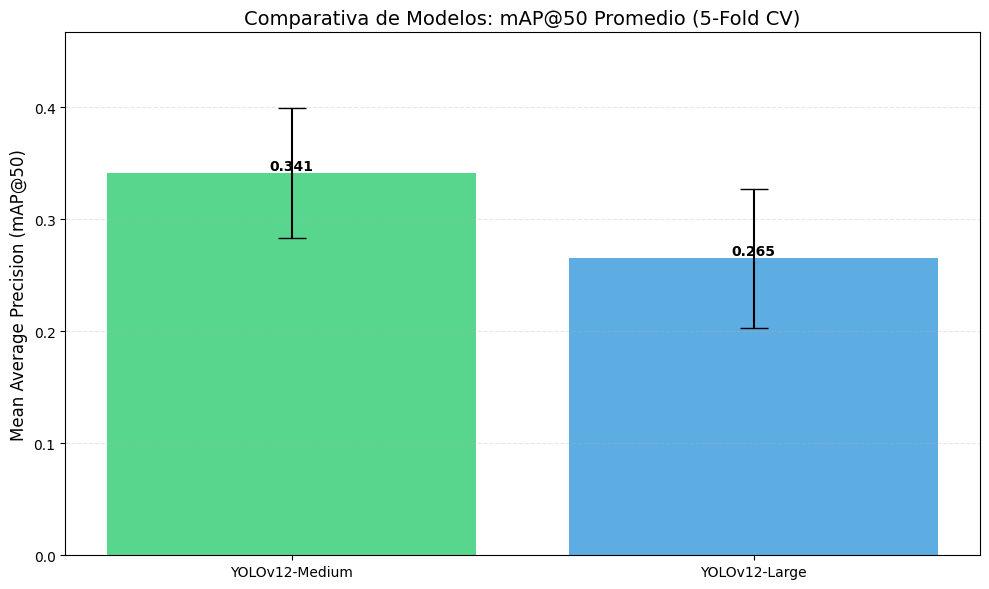

In [8]:
# Configuración
MODELS = [
    {'suffix': 'n', 'name': 'YOLOv12-Nano'},
    {'suffix': 'm', 'name': 'YOLOv12-Medium'},
    {'suffix': 'l', 'name': 'YOLOv12-Large'}
 ]
NUM_FOLDS = 5

final_summary = []
raw_data = {} # Para guardar todos los puntos y poder plotear

print(f"{'Modelo':<15} | {'Fold':<5} | {'mAP@50 (Rescatado)':<20}")
print('-' * 45)

for model in MODELS:
    suffix = model['suffix']
    display_name = model['name']
    
    maps_for_this_model = []
    
    for i in range(1, NUM_FOLDS + 1):
        # Construir la ruta al archivo de logs CSV
        # Estructura: Corrosion_Benchmark / n_fold_1 / results.csv
        run_name = f'{suffix}_fold_{i}'
        csv_path = Path(PROJECT_NAME) / run_name / 'results.csv'
        
        if csv_path.exists():
            try:
                # Leemos el CSV generado por YOLO
                df = pd.read_csv(csv_path)
                
                # Limpiamos nombres de columnas (suelen tener espacios extra)
                df.columns = [c.strip() for c in df.columns]
                
                # Obtenemos el mejor mAP@50 de toda la historia de entrenamiento de este fold
                # La columna suele llamarse 'metrics/mAP50(B)'
                best_map = df['metrics/mAP50(B)'].max()
                
                maps_for_this_model.append(best_map)
                print(f'{display_name:<15} | {i:<5} | {best_map:.4f}')
                
            except Exception as e:
                print(f'{display_name:<15} | {i:<5} | Error leyendo CSV: {e}')
        else:
            print(f'{display_name:<15} | {i:<5} | ⚠️ Archivo no encontrado (¿No terminó?)')

    # Calculamos estadísticas si encontramos datos
    if maps_for_this_model:
        mean_map = np.mean(maps_for_this_model)
        std_map = np.std(maps_for_this_model)
        
        final_summary.append({
            'Architecture': display_name,
            'Mean mAP@50': mean_map,
            'Std Dev': std_map,
            'Best Single Fold': np.max(maps_for_this_model),
            'Worst Single Fold': np.min(maps_for_this_model)
        })
        raw_data[display_name] = maps_for_this_model

# --- VISUALIZACIÓN ---
print('' + '='*60)
print(' TABLA COMPARATIVA PARA EL PAPER (LaTeX Ready) ')
print('='*60)
df_final = pd.DataFrame(final_summary)
# Ordenar por mAP descendente para ver el ganador
df_final = df_final.sort_values(by='Mean mAP@50', ascending=False)
print(df_final.to_string(index=False, float_format='%.4f'))

if not df_final.empty:
    # Gráfico de Barras con Error Bars
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_final['Architecture'], df_final['Mean mAP@50'], 
            yerr=df_final['Std Dev'], capsize=10, 
            color=['#2ecc71', '#3498db', '#e74c3c'], alpha=0.8)
    
    plt.title('Comparativa de Modelos: mAP@50 Promedio (5-Fold CV)', fontsize=14)
    plt.ylabel('Mean Average Precision (mAP@50)', fontsize=12)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.ylim(0, max(df_final['Best Single Fold']) * 1.15) # Un poco más alto que el mejor
    
    # Poner etiquetas de valor encima de las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print('⚠️ No se encontraron datos. Asegúrate de que la carpeta Corrosion_Benchmark existe y contiene los resultados.')